# Prilog: **Nesterovljev ubrzani gradijentni metod za minimizaciju (NAG)**  

*Implementacija unutar Julia programskog jezika* 

---

Za potrebe istoimenog seminarskog rada iz kursa _Numerički algoritmi_, prilažemo **implementaciju algoritma** uz primjenu na _poznatim problemima iz oblasti numeričkih metoda_, napisani u **Julia programskom jeziku**.

### 1. **Definicije**

---


 **Standardna formulacija Nesterovljeve metode**   
>
> $y_{k} = x_k + \mu\, v_k$  
> $v_{k+1} = \mu\, v_k - \alpha \nabla f(y_k) \quad \{v_0 = \vec{0}\}$   
> $x_{k+1} = x_k + v_{k+1}$  

**Gdje je:**  

> $v_{k}$ - Brzina spusta gradijenta u $k$-toj iteraciji _(Velocity)_  
> $\alpha$ - Stopa učenja _(Learning rate)_   
> $\mu$ - Koeficijent momentuma spusta  

Alternativno, u praktičnim primjenama, u literaturi se pojavljuju **i druge formulacije Nesterovljeve metode**. 

Među najpoznatijima su formulacije koje su predložili ***Sutskever et al.*** (2013), te ***Bengio*** (2012), koje prilagođavaju originalnu metodu kako bi je učinili pogodnijom za **primjenu u treniranju rekurentnih i dubokih neuronskih mreža _(RNN & DNN)_**.

#### 1.1 **Sutskeverova formulacija metode** (Sutskever et al., 2013.)


Ključna ideja Sutskeverove modifikacije je **_'fazno'_ pomjeranje za pola iteracije**.

Umjesto redoslijeda _**"gradijent → momentum"**_, granica iteracije se pomjera tako da se
dobije redoslijed _**"momentum → gradijent"**_.  
Rezultat je matematički ekvivalentna formulacija koja radi nad parametrima $\phi$ umjesto
$\theta$, koja se pokazuje pogodnijom za potrebe _dubokog učenja_.


$$
\phi_{t+1} = \phi_t + \mu v_t - \alpha \nabla f(\phi_t + \mu v_t)
$$

> **Parametri $\phi$ na kraju svake iteracije već su postavljeni na _look-ahead_ poziciju.**  
> Tako, sljedeća iteracija automatski evaluira gradijent na ispravnom mjestu, 
> te **nema potrebe za eksplicitnim održavanjem dva odvojena vektora parametara** kao u
> originalnoj Nesterovljevoj formulaciji, ostajući **u skladu sa standardnim gradijentnim metodama.**

_Ova modifikacija je danas prisutna u mnogim softverskim okvirima _(framework-ima)_ za
_duboko učenje_, kao što je **PyTorch**._

#### 1.2 **Bengiova formulacija metode** (Bengio, 2012.)


Bengiova formulacija nastaje kao alternativa **Sutskeverovoj**, s ciljem lakše integracije 
u postojeće softverske okvire _(framework-e)_.  
 Ključna prednost je što **ne zahtijeva računanje gradijenta 
na nestandardnoj poziciji** — dovoljno je samo modificirati koeficijente u proračunu spusta, što je znatno jednostavnija izmjena u kodnoj bazi koja već koristi standardni gradijenti spust sa momentumom.


Razvijanjem Sutskeverove formulacije i sređivanjem članova, dobija se matematički ekvivalentan izraz:

$$
\theta_{t+1} = \theta_t + \mu_{t-1}\mu_t b_t - (1+\mu_t)\alpha_t \nabla f(\theta_t)
$$
Gdje je, 
$$
b_{t+1} = \mu_t b_t - \alpha_t \nabla f(\theta_t)
$$

> **Bengiova formulacija** pokazuje da je _look-ahead_ perspektiva samo jedan način gledanja, te da se NAG ekvivalentno 
> može posmatrati kao momentum s **korigiranim koeficijentima**, gdje metoda primjenjuje **veći efektivni korak gradijenata** i **manji efektivni korak momentuma**.  što je pogodnije za analizu stabilnosti treniranja _RNN_.


### 2. **Formulacija metode u programskom kodu**

---

In [ ]:
# -------------------------------------------------
# Nesterovljeva metoda za minimizaciju - Standardna formulacija
# -------------------------------------------------

function nag(x0, func, gradient;
             learning_rate = 0.001,
             momentum_coeff = 0.9,
             max_iter = 5000,
             eps = 1e-7)

    v = zeros(length(x0)) # Brzina spusta
    x = copy(x0) # Trenutna pozicija

    path = [copy(x)] # Za potrebe grafičkog prikaza kretanja metode
    for i in 1:max_iter
        look_ahead = x .+ momentum_coeff .* v
        grad_x = gradient(look_ahead)
        if norm(grad_x) < eps
            break
        end
        v = momentum_coeff .* v .- learning_rate .* grad_x
        x = x .+ v

       push!(path, copy(x))
    end
    push!(path, copy(x))
    return (x=x,f=func(x),path=path)
end

nag (generic function with 1 method)

> ***Sutskever formulacija Nesterovljeve metode***

In [ ]:
# -------------------------------------------------
# Nesterovljeva metode za minimizaciju - Sutskeverova formulacija
# -------------------------------------------------


function nag_sutskever(x0, func, gradient;
                       learning_rate  = 0.001,
                       momentum_coeff = 0.9,
                       max_iter       = 5000,
                       eps            = 1e-7)

    v    = zeros(length(x0))
    x    = copy(x0)
    path = [copy(x)]

    for i in 1:max_iter
        v_prev = copy(v)
        v      = momentum_coeff .* v .- learning_rate .* gradient(x .+ momentum_coeff .* v)
        x      = x .+ v
        if norm(grad) < eps 
            break
        end
        push!(path, copy(x))
    end
    push!(path, copy(x))
    return (x=x, f=func(x), path=path)
end


nag_sutskever (generic function with 1 method)

> ***Bengio formulacija Nesterovljeve metode***

Ovdje ćemo našu implementaciju Bengiove formulacije prikazati sa blagim odstupanjem od teoretske u jednoj ključnoj tački:  
> $\mu_{t-1}\mu_t$ se aproksimira kao $\mu^2$, što je ispravno samo kada je $\mu = const.$ kroz sve iteracije.   

U teoretskoj formulaciji $\mu_t$ može biti raspoređen
_(scheduled)_ po iteracijama, što bi zahtijevalo eksplicitno praćenje $\mu_{t-1}$.  

Dodatno, vektor $b_t$ iz teoretske formulacije predstavlja razliku parametara 
$\phi_{t+1} - \phi_t$, dok implementacija koristi $v_t$ koji se ažurira standardnom
momentum formulom   
$v = \mu v - \alpha \nabla f(\theta)$ što je ekvivalentno
samo pod pretpostavkom $\mu = const.$

_Za potrebe ovog rada, gdje je $\mu$ fiksan, ova aproksimacija ne uvodi grešku. Slučajevi gdje je zaista nezanemarljiva greška posljedicom ove aproksimacije su češto veoma specifični, te van sklopa ovog rada, a služe boljoj vizualizaciji ekvivalencije sa originalnom formulacijom._

In [ ]:
function nag_bengio(x0, func, gradient;
                    learning_rate  = 0.001,
                    momentum_coeff = 0.9,
                    max_iter       = 5000,
                    eps            = 1e-7)

    v    = zeros(length(x0))
    x    = copy(x0)
    path = [copy(x)]

    for i in 1:max_iter
        grad = gradient(x)
        if norm(grad) < eps 
            break
        end

        if i == 1
            x = x .- learning_rate .* grad
        else
            x = x .+ momentum_coeff^2 .* v .- (1 + momentum_coeff) .* learning_rate .* grad
            v = momentum_coeff .* v .- learning_rate .* grad
        end

        push!(path, copy(x))
    end
    push!(path, copy(x))
    return (x=x, f=func(x), path=path)
end

nag_bengio (generic function with 1 method)

Za potrebe ove aproksimacije, potrebno je obratiti pažnju na dodatni problem u prvoj iteraciji, $i=1$: 

>U prvoj iteraciji radimo čisti gradijentni spust (bez momentuma).  
> **Razlog:** $\mu_{t-1}\mu_t = 0 \cdot \mu = 0$, pa momentum član ispada.
>
>Ako bismo ažurirali $v$ na prvoj iteraciji, narušili bismo pretpostavku
$\mu_t \cdot \mu_{t-1} \approx \mu^2$ za iteraciju $t=2$, jer bi $\mu_1 = 0 \neq \mu$.

*Rješenje ove anomalije preuzimamo od James Melville-a, autora paketa 
<a href="https://github.com/jlmelville/mize">mize</a>
 za algoritme numeričke minimizacije funkcija u programskom jeziku R, gdje je više o ovom pisao u svom članku (Melville, 2016).*

### 3. ***Primjer i vizualizacija primjene metode***  
 *Minimizacija Rosenbrockove funkcije* 

---


#### 3.1 **Rosenbrockova funkcija**

**Rosenbrockova funkcija** _(Rosenbrock, 1960)_ je klasična testna funkcija u oblasti
numeričke optimizacije, definisana kao:

$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$

Globalni minimum se nalazi u tački $(x, y) = (a, a^2)$, tako da za učestale parametre **$a = 1,\ b = 100, f(1, 1) = 0$**.

Funkcija je poznata po svojoj **uskoj, zakrivljenoj dolini** koja vodi prema minimumu —
dolina je lako pronađena, ali konvergencija unutar nje je spora zbog zakrivljenosti
i loše uvjetovanosti _(ill-conditioning)_. Upravo zbog toga se koristi kao standardni
_benchmark_ za testiranje metoda minimizacije, posebno gradijentnih metoda s momentumom.

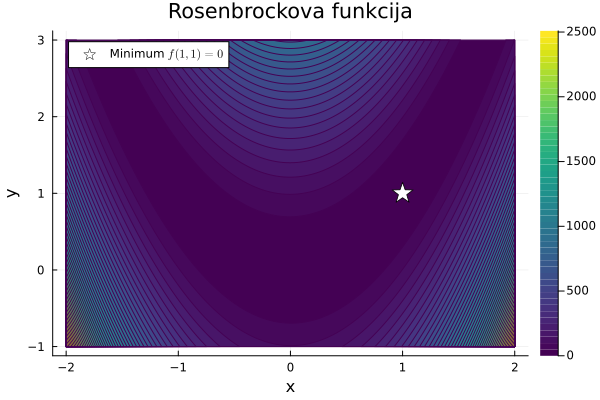

In [34]:
rosenbrock(x) = (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2

function rosenbrock_grad(x)
    dx1 = -2*(1 - x[1]) - 400*x[1]*(x[2] - x[1]^2)
    dx2 =  200*(x[2] - x[1]^2)
    [dx1, dx2]
end

contourf(-2:0.01:2, -1:0.01:3, 
    [rosenbrock([x,y]) for y in -1:0.01:3, x in -2:0.01:2];
    levels=50, color=:viridis,title="Rosenbrockova funkcija", xlabel="x", ylabel="y")

scatter!([1.0], [1.0];
    marker            = :star5,
    markersize        = 11,
    color             = :white,
    markerstrokecolor = :black,
    label             = "Minimum \$f(1,1) = 0\$")

Primjenjimo sada sve tri prikazane formulacije metode na funkciju.

NAG (classic)   - iteracije: 3576,   x*: [1.0, 1.0],   f*: 1.259e-14
NAG (Sutskever) - iteracije: 1153, x*: [0.99744, 0.99488], f*: 6.556e-6
NAG (Bengio)    - iteracije: 3617, x*: [1.0, 1.0], f*: 1.247e-14


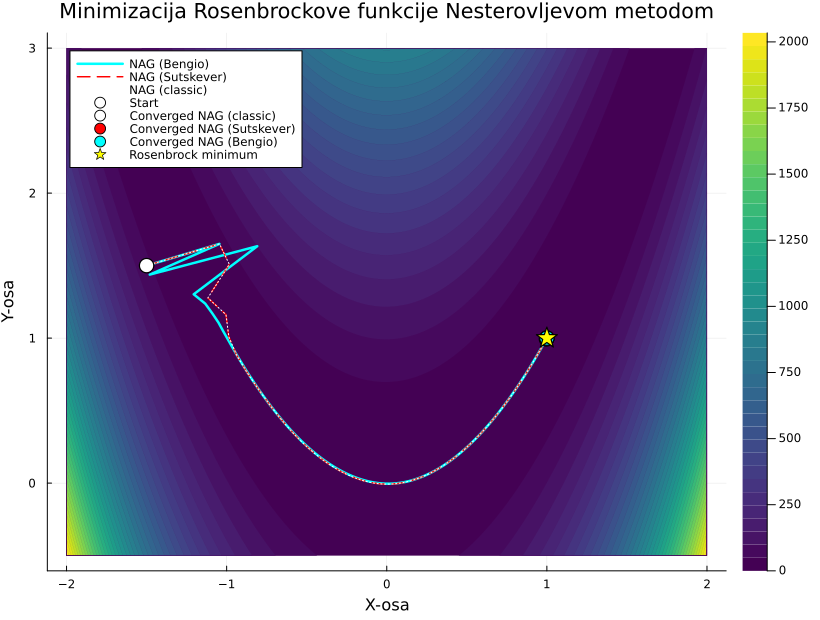

In [39]:
using Plots, LinearAlgebra
x0       = [-1.5, 1.5]
result   = nag(x0, rosenbrock, rosenbrock_grad)
result_s = nag_sutskever(x0, rosenbrock, rosenbrock_grad)
result_b = nag_bengio(x0, rosenbrock, rosenbrock_grad)

println("NAG (classic)   - iteracije: $(length(result.path)-1),   x*: $(round.(result.x, digits=5)),   f*: $(round(result.f, sigdigits=4))")
println("NAG (Sutskever) - iteracije: $(length(result_s.path)-1), x*: $(round.(result_s.x, digits=5)), f*: $(round(result_s.f, sigdigits=4))")
println("NAG (Bengio)    - iteracije: $(length(result_b.path)-1), x*: $(round.(result_b.x, digits=5)), f*: $(round(result_b.f, sigdigits=4))")

xs = -2:0.02:2
ys = -0.5:0.02:3.0
Z  = [rosenbrock([x, y]) for y in ys, x in xs]

path_x  = [p[1] for p in result.path];   path_y  = [p[2] for p in result.path]
path_xs = [p[1] for p in result_s.path]; path_ys = [p[2] for p in result_s.path]
path_xb = [p[1] for p in result_b.path]; path_yb = [p[2] for p in result_b.path]

contourf(xs, ys, Z; levels=40, color=:viridis, linewidth=0,
    xlabel="X-osa", ylabel="Y-osa",
    title="Minimizacija Rosenbrockove funkcije Nesterovljevom metodom",
    size=(820, 620))

plot!(path_xb, path_yb; color=:cyan,  linewidth=2.5, label="NAG (Bengio)",    linestyle=:solid)
plot!(path_xs, path_ys; color=:red,   linewidth=1.5, label="NAG (Sutskever)", linestyle=:dash)
plot!(path_x,  path_y;  color=:white, linewidth=1.0, label="NAG (classic)",   linestyle=:dot)

scatter!([x0[1]], [x0[2]]; color=:white,  markersize=8, marker=:circle, label="Start")
scatter!([path_x[end]],  [path_y[end]];  color=:white, markersize=8, label="Converged NAG (classic)")
scatter!([path_xs[end]], [path_ys[end]]; color=:red,   markersize=8, label="Converged NAG (Sutskever)")
scatter!([path_xb[end]], [path_yb[end]]; color=:cyan,  markersize=8, label="Converged NAG (Bengio)")
scatter!([1.0], [1.0]; color=:yellow, markersize=11, marker=:star5, label="Rosenbrock minimum")

---

### **Literatura**

- Sutskever, I., Martens, J., Dahl, G., Hinton, G. (2013). *On the importance of 
  initialization and momentum in deep learning*. ICML, PMLR 28.

- Bengio, Y. (2012). *Practical Recommendations for Gradient-Based Training of 
  Deep Architectures*. Neural Networks: Tricks of the Trade, Springer.

- Melville, J. (2016). *Nesterov Accelerated Gradient and Momentum*. 
Preuzeto sa https://jlmelville.github.io/mize/nesterov.html

- Rosenbrock, H. H. (1960). An automatic method for finding the greatest or least value 
of a function. *The Computer Journal*, 3(3), 175–184. 
https://doi.org/10.1093/comjnl/3.3.175